# Prediction of trial epoch with 
Jan2024
@author:Ines

In [2]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

# --Machine learning and statistics
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, confusion_matrix

from one.api import ONE

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from plotting_functions import bins_per_trial_phase, broader_label

one = ONE()

## Parameters

In [3]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
# data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Load data

List design matrices' eids

In [130]:
# Save data of all sessions for latter
idxs = []
mouse_names = []
for m, mat in enumerate(design_matrices):
    
    mouse_name = design_matrices[m][51:-4]
    eid = design_matrices[m][14:50]
    idx = str(eid + '_' + mouse_name)
    if m == 0:
        idxs = idx
        mouse_names = mouse_name
    else:
        idxs = np.hstack((idxs, idx))
        mouse_names = np.hstack((mouse_names, mouse_name))

## Preprocess data

In [131]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mouse_name in enumerate(mouse_names):
    # Save results per mouse
    matrix_all[mouse_name] = {}
    session_all[mouse_name] = {}
    matrix_all_unnorm[mouse_name] = {}

for m, mat in enumerate(idxs):
    if len(mat) > 35: 
            
        # Trials data
        session = mat[0:36]
        mouse_name = mat[37:]

        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()
        session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
        session_start = list(session_trials['stimOn_times'])[0]

        # Get time of last unbiased trial
        unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
        time_trial_90 = list(unbiased['stimOff_times'])[-1]
        
        filename = str('design_matrix_' + mat + '_'  + str(bin_size))  # + mouse_name + '_'
                
        big_design_matrix = pickle.load(open(filename, "rb"))
        design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
        design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
        design_matrix = design_matrix.dropna()
    
        # Keep only first 90 trials
        design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90 * 10) & (design_matrix['Bin'] > session_start * 10)]
        unbiased_trials = session_trials.loc[session_trials['stimOff_times'] < time_trial_90]
        training_set = np.array(design_matrix[var_names]).copy() 
        
        if len(training_set) > 0:
            # Standardization using StandardScaler
            scaler = StandardScaler()
            standardized = scaler.fit_transform(training_set)
            # Normalize between 0 and 1
            normalizer = Normalizer().fit(standardized)
            normalized = normalizer.transform(standardized)
            
            matrix_all[mouse_name][session] = normalized
            session_all[mouse_name][session] = unbiased_trials    
            matrix_all_unnorm[mouse_name][session] = design_matrix
            
        else:
            print(session)
    else:
        print(mat)

local md5 mismatch on dataset: churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.60k/4.60k [00:00<00:00, 13.0kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.26k/5.26k [00:00<00:00, 14.3kB/s]


_
poch_DY_013.png_


local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.35k/5.35k [00:00<00:00, 14.2kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.38k/4.38k [00:00<00:00, 13.0kB/s]


lls_
_
poch_CSHL060.png_
_matrix_


local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.38k/5.38k [00:00<00:00, 16.4kB/s]


1b61b7f2-a599-4e40-abd6-3e758d2c9e25
_


## Concatenate sessions of the same animal

In [113]:
collapsed_matrices = defaultdict(list)
collapsed_unnorm = defaultdict(list)
collapsed_trials = defaultdict(list)

# Collapse multiple sessions per mouse
for mouse in np.unique(mouse_names):
    if len(np.where(mouse_names==mouse)[0]) > 1 and len(mouse) > 0:
        mouse_sessions = list(matrix_all[mouse].keys())
        for s, session in enumerate(mouse_sessions):
            collapsed_matrices[mouse] = np.vstack(matrix_all[mouse][session])
            collapsed_unnorm[mouse] = np.vstack(matrix_all_unnorm[mouse][session])
            collapsed_trials[mouse] = pd.concat(session_all[mouse], ignore_index=True)

In [157]:
def broader_label(df, broader):
    
    df['broader_label'] = df['label']
    
    if broader == True:
        df.loc[df['broader_label']=='Stimulus right', 'broader_label'] = 'Pre-choice'
        df.loc[df['broader_label']=='Stimulus left', 'broader_label'] = 'Pre-choice'
        df.loc[df['broader_label']=='Quiescence', 'broader_label'] = 'Pre-choice'
        df.loc[df['broader_label']=='Left choice', 'broader_label'] = 'Choice'
        df.loc[df['broader_label']=='Right choice', 'broader_label'] = 'Choice'
        df.loc[df['broader_label']=='Correct feedback', 'broader_label'] = 'Post-choice'
        df.loc[df['broader_label']=='Incorrect feedback', 'broader_label'] = 'Post-choice'
        df.loc[df['broader_label']=='ITI_correct', 'broader_label'] = 'Post-choice'
        df.loc[df['broader_label']=='ITI_incorrect', 'broader_label'] = 'Post-choice'
    else:
        df.loc[df['broader_label']=='Stimulus right', 'broader_label'] = 'Stimulus'
        df.loc[df['broader_label']=='Stimulus left', 'broader_label'] = 'Stimulus'
        df.loc[df['broader_label']=='Quiescence', 'broader_label'] = 'Quiescence'
        df.loc[df['broader_label']=='Left choice', 'broader_label'] = 'Choice'
        df.loc[df['broader_label']=='Right choice', 'broader_label'] = 'Choice'
        df.loc[df['broader_label']=='Correct feedback', 'broader_label'] = 'ITI'
        df.loc[df['broader_label']=='Incorrect feedback', 'broader_label'] = 'ITI'
        df.loc[df['broader_label']=='ITI_correct', 'broader_label'] = 'ITI'
        df.loc[df['broader_label']=='ITI_incorrect', 'broader_label'] = 'ITI'
    
    return df


def run_decoder (use_mat, var, broader, model, shufflings, repetitions):
    
    # Create empty dataframes to save results
    decoding_result = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix'])

    # Decoding function with 10-fold cross validation
    kf = KFold(n_splits=10, shuffle=True, random_state=0)

    # Find minimum number of samples per label
    labels = np.array(use_mat[var])
    labels_nr = np.arange(labels.shape[0])

    if broader == True:
        label_freq = [len(use_mat.loc[use_mat[var]==1]), len(use_mat.loc[use_mat[var]==2]), 
                    len(use_mat.loc[use_mat[var]==3])]
    else:
        label_freq = [len(use_mat.loc[use_mat[var]==1]), len(use_mat.loc[use_mat[var]==2]), 
                    len(use_mat.loc[use_mat[var]==3]), len(use_mat.loc[use_mat[var]==4])]
    min_freq = np.min(label_freq)

    # Randomly select N mice from each lab to equalize classes
    use_index = np.empty(0, dtype=int)
    for j, epoch in enumerate(np.unique(labels)):
        use_index = np.concatenate([use_index, np.random.choice(labels_nr[labels == epoch],
                                                                min_freq, replace=False)])

    new_mat = use_mat.iloc[use_index].reset_index().drop(columns=['index']).copy()
            
    # -- ORIGINAL DATASET

    dec_result = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix'])

    y_pred = np.zeros(len(new_mat), dtype=int) 
    # exog = new_mat[new_mat.columns.difference([var])]
    exog = new_mat[new_mat.columns.difference([var, 'correct', 'choice', 'signed_contrast'])]
    endog = new_mat.loc[:, var]

    for train_index, test_index in kf.split(new_mat):
        model.fit(exog.iloc[train_index], endog.iloc[train_index].astype(int))
        y_pred[test_index] = model.predict(exog.iloc[test_index])

    # Calculate f1 score and confusion matrix
    f1 = f1_score(endog.astype(int), y_pred.astype('int'), average='micro')
    cm = confusion_matrix(endog.astype(int), y_pred.astype('int'), normalize='true')

    # Save results
    dec_result.loc[0, 'f1'] = f1
    dec_result.loc[0, 'confusion_matrix'] = cm
    dec_result.loc[0, 'shuffle'] = 0

    decoding_result = pd.concat([decoding_result, dec_result])


    # -- DETERMINE FEATURE IMPORTANCE BY PERMUTING FEATURE VALUES

    features = exog.keys() 
    permutation_result = pd.DataFrame(columns=['repetition', 'feature', 'f1'])
        
    # Score of original non-cross-validated model    
    original_model = model.fit(exog, endog.astype(int))
    original_pred = np.zeros(len(exog), dtype=int) 
    original_pred = model.predict(exog)
    original_f1 = f1_score(endog.astype(int), original_pred.astype('int'), average='micro')

    # Loop over each feature 
    for f, feature in enumerate(features):

        # Permute each feature several times
        perm_result = pd.DataFrame(columns=['repetition', 'feature', 'f1'])
        for n in range(repetitions):
        
            permuted_exog = exog.copy()
            permuted_exog[features[f]] = np.random.permutation(permuted_exog[features[f]].values)
            
            #  Fit model and make predictions
            model.fit(exog, endog.astype(int))
            permuted_y_pred = np.zeros(len(exog), dtype=int)
            permuted_y_pred = model.predict(permuted_exog)
            
            # Calculate f1 score for model with permuted feature
            permuted_f1 = f1_score(endog.astype(int), permuted_y_pred.astype('int'), average='micro')

            # Save results
            perm_result.loc[n, 'repetition'] = n
            perm_result.loc[n, 'feature'] = features[f]
            perm_result.loc[n, 'f1'] = permuted_f1
        
        permutation_result = pd.concat([permutation_result, perm_result])

    # -- SHUFFLED DATASET 

    shuffle_result = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix'])

    for s in range(shufflings):
        if np.mod(s+1, 10) == 0:
            print('Shuffling %d of %d' % (s+1, shufflings))   

        shuffle_y_pred = np.zeros(len(new_mat), dtype=int) 
        shuffle_endog = endog.copy()
        np.random.shuffle(shuffle_endog.values)

        for train_index, test_index in kf.split(new_mat):
            model.fit(exog.iloc[train_index], list(shuffle_endog.iloc[train_index].astype(int)))
            shuffle_y_pred[test_index] = model.predict(exog.iloc[test_index])   

        shuffle_f1 = f1_score(shuffle_endog.astype(int), shuffle_y_pred.astype('int'), average='micro')
        shuffle_cm = confusion_matrix(shuffle_endog.astype(int), shuffle_y_pred.astype('int'), normalize='true')

        # SAVE
        shuffle_result.loc[s, 'f1'] = shuffle_f1
        shuffle_result.loc[s, 'confusion_matrix'] = shuffle_cm
        shuffle_result.loc[s, 'shuffle'] = s + 1

    decoding_result = pd.concat([decoding_result, shuffle_result])
    
    return decoding_result, permutation_result, original_f1

## Loop through animals and get accuracy + feature importance

In [196]:
# p_values = pd.DataFrame(columns=['mouse', 'var', 'epoch', 'significance'])
shufflings = 100  #shuffling
repetitions = 10  # permutation repetitions
model = GaussianNB()
broader = False
var = 'broader_label'

all_animals_df = pd.DataFrame(columns=np.concatenate((['mouse_name', 'session', 
                                                       'f1_model'], var_names)), index=range(len(idxs)))

for m, mat in enumerate(idxs):
    if len(mat) > 35: 
            
        # Trials data
        session = mat[0:36]
        # Mouse name
        mouse_name = mat[37:]
        
        print('Fitting mouse ' + mouse_name)

        # Get mouse data
        session_trials = session_all[mouse_name][session]
        design_matrix = matrix_all[mouse_name][session]
        unnorm_mat = matrix_all_unnorm[mouse_name][session]
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            unnorm_mat = matrix_all_unnorm[mouse_name][0]

        " Prepare design matrix "
        design_matrix_heading = pd.DataFrame(columns=var_names)
        design_matrix_heading[var_names] = design_matrix
        bins = unnorm_mat['Bin']
        design_matrix_heading['Bin'] = bins
        
        design_matrix_heading['avg_wheel_vel'] = np.abs(design_matrix_heading['avg_wheel_vel'])

        # Get trial phase
        bins_df = bins_per_trial_phase(design_matrix_heading, session_trials)
        bins_df = bins_df.rename(columns={0: 'Bin'})
        new_df = design_matrix_heading.merge(bins_df, on='Bin')
        # melted = pd.melt(new_df, id_vars=['Bin', label, 'Trial'], value_vars=np.array(var_names))

        # Get broader labels
        new_df = broader_label(new_df, broader)

        # --Remove NaNs and mouse column from design matrix
        mat = new_df.drop(columns=['Bin', 'Trial', 'label'])
        mat = mat.dropna()
        mat = mat.drop_duplicates()
        if broader == True:
            mat[var] = mat[var].replace(['Pre-choice', 'Choice', 'Post-choice'],
                            [1, 2, 3])
        else:
            mat[var] = mat[var].replace(['Quiescence', 'Stimulus', 'Choice', 'ITI'],
                            [1, 2, 3, 4])
            
        """
        RUN MODEL
        """
        decoding_result, permutation_result, original_f1 = run_decoder(mat, var, broader, model, shufflings, repetitions)
        # -- Permutation tests for full model
        # f1_model = decoding_result.loc[decoding_result['shuffle']==0, 'f1'][0]
        data = permutation_result.copy()
        data['f1'] = data['f1'].astype(float)
        data['f1'] = original_f1 - data['f1']
        plot_order = data.groupby('feature')['f1'].mean()
        
        # Save results
        all_animals_df['mouse_name'][m] = mouse_name
        all_animals_df['session'][m] = session
        all_animals_df['f1_model'][m] = decoding_result.loc[decoding_result['shuffle'] == 0, 'f1'].mean()
        for var_name in var_names:
            all_animals_df[var_name][m] =  plot_order[var_name]
        
melted = pd.melt(all_animals_df, id_vars=['mouse_name', 'session'], value_vars=np.array(var_names))

Fitting mouse SWC_052


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZFM-02369


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse SWC_061


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse CSHL049


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse NR_0019


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse SWC_053


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse CSHL058


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZFM-01936


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse SWC_043


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse KS023


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse SWC_053


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZM_2240


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse DY_018


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse CSHL058


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZM_2240


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZFM-01592


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse CSHL045


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZM_3003


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse DY_010


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZFM-01935


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse DY_016


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse SWC_052


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse SWC_054


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse UCLA037


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse CSHL045


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ibl_witten_29


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse NYU-37


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse NR_0020


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZM_1898


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZFM-01936


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse KS084


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse KS091


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse KS023


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse NYU-40


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse KS022


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse UCLA033


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse DY_016


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse CSHL059


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZFM-02372


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse PL017


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse CSHL045


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZFM-01936


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse NR_0020


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ibl_witten_29


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse UCLA012


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse CSHL054


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZM_3003


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse CSHL051


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZFM-01936


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse DY_013


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse CSHL060


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse KS023


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZFM-01935


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse PL017


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse PL015


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse SWC_066


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse NYU-39


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse DY_016


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse PL015


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse KS014


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse DY_014


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse CSHL060


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse DY_014


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ibl_witten_29


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse SWC_043


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse KS014


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse UCLA037


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse PL016


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse CSHL047


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ibl_witten_29


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse DY_014


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse NYU-40


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse DY_008


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse SWC_058


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse SWC_054


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse NYU-45


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse SWC_053


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse KS096


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse CSHL045


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse DY_016


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse SWC_052


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse CSHL060


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse DY_009


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse SWC_043


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse CSHL059


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse KS096


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse DY_014


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse CSHL052


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ibl_witten_25


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZFM-02372


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZFM-02373


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ibl_witten_29


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZM_2245


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse NYU-37


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse KS086


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse SWC_065


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZFM-01936


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse KS044


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse KS096


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ibl_witten_29


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse CSHL059


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZFM-01592


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse UCLA034


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse DY_014


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZFM-01935


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse PL015


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse CSHL047


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse KS096


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse CSHL049


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZM_2241


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse DY_014


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZM_2241


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse NR_0027


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZM_2240


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ibl_witten_26


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse NYU-37


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse CSHL058


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse SWC_058


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse DY_018


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZFM-02370


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ibl_witten_26


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse DY_009


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse SWC_052


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse SWC_043


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse DY_018


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ibl_witten_29


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse KS051


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZM_1898


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse NR_0019


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse NYU-45


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZM_2241


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ibl_witten_26


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse SWC_052


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZM_2241


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse CSHL059


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse NYU-45


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse DY_014


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse KS023


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZFM-01935


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZM_2241


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse NR_0020


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse NYU-37


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse UCLA033


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse PL015


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse ZM_2240


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse CSHL060


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse SWC_058


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse UCLA035


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse SWC_058


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse KS014


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse SWC_043


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Fitting mouse PL017


KeyError: '1b61b7f2-a599-4e40-abd6-3e758d2c9e25'

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 17.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 21.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 16.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 24.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/i

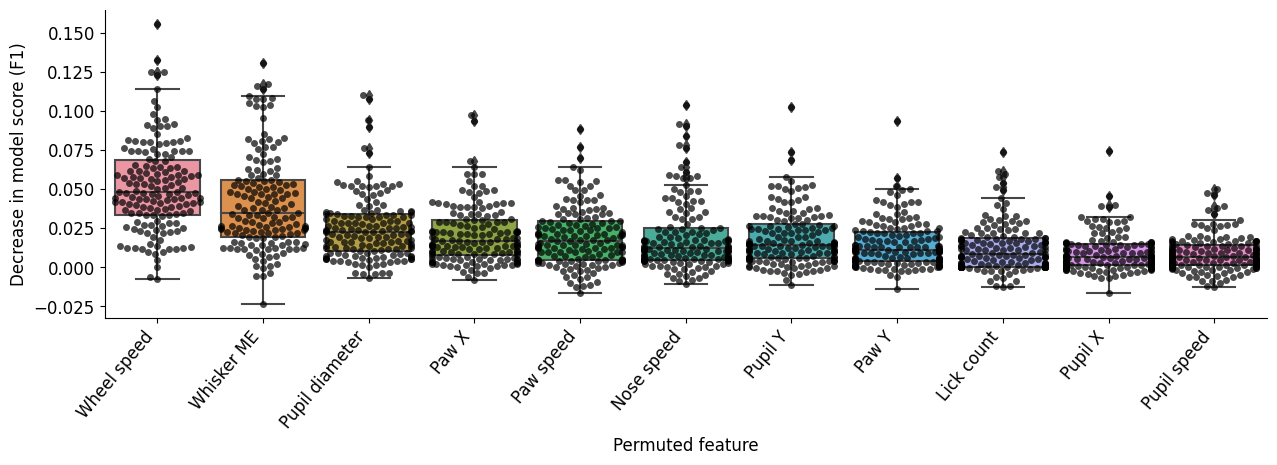

In [197]:
melted = pd.melt(all_animals_df, id_vars=['mouse_name', 'session'], value_vars=np.array(var_names))
data = melted.replace(var_names, ['Wheel speed', 'Pupil diameter',
    'Whisker ME', 'Nose speed', 'Paw speed', 
    'Paw X', 'Paw Y',
    'Pupil speed', 'Pupil X', 'Pupil Y', 'Lick count'])

plot_order = data.groupby('variable')['value'].mean().sort_values(ascending=False).index.values
plt.figure(figsize=[15,4])
plt.rc('font', size=12) 
sns.boxplot(x='variable', y='value', data=data, 
    order=plot_order, orient='v') 
sns.swarmplot(x='variable', y='value', data=data, 
    order=plot_order, orient='v', color='black', alpha=0.7) 
plt.xlabel('Permuted feature')
plt.ylabel('Decrease in model score (F1)')
ha = 'right'
plt.xticks(rotation=50, ha=ha)
sns.despine(top=True, right=True)


## For a single session

In [117]:

"""
RUN MODEL
"""

# Generate random states for each iteration with a fixed seed
# Loop over iterations of random draws of mice

shufflings = 100  #shuffling
repetitions = 10  # permutation repetitions
model = GaussianNB()
# Create empty dataframes to save results
decoding_result = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix'])

# Decoding function with 10-fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=0)
use_mat = mat.copy() # test using all mice

# Find minimum number of samples per label
labels = np.array(use_mat[var])
labels_nr = np.arange(labels.shape[0])

if broader == True:
    label_freq = [len(use_mat.loc[use_mat[var]==1]), len(use_mat.loc[use_mat[var]==2]), 
                len(use_mat.loc[use_mat[var]==3])]
else:
    label_freq = [len(use_mat.loc[use_mat[var]==1]), len(use_mat.loc[use_mat[var]==2]), 
                len(use_mat.loc[use_mat[var]==3]), len(use_mat.loc[use_mat[var]==4])]
min_freq = np.min(label_freq)

# Randomly select N mice from each lab to equalize classes
use_index = np.empty(0, dtype=int)
for j, epoch in enumerate(np.unique(labels)):
    use_index = np.concatenate([use_index, np.random.choice(labels_nr[labels == epoch],
                                                            min_freq, replace=False)])

new_mat = use_mat.iloc[use_index].reset_index().drop(columns=['index']).copy()
        
# -- ORIGINAL DATASET

dec_result = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix'])

y_pred = np.zeros(len(new_mat), dtype=int) 
# exog = new_mat[new_mat.columns.difference([var])]
exog = new_mat[new_mat.columns.difference([var, 'correct', 'choice', 'signed_contrast'])]
endog = new_mat.loc[:, var]

for train_index, test_index in kf.split(new_mat):
    model.fit(exog.iloc[train_index], endog.iloc[train_index].astype(int))
    y_pred[test_index] = model.predict(exog.iloc[test_index])

# Calculate f1 score and confusion matrix
f1 = f1_score(endog.astype(int), y_pred.astype('int'), average='micro')
cm = confusion_matrix(endog.astype(int), y_pred.astype('int'), normalize='true')

# Save results
dec_result.loc[0, 'f1'] = f1
dec_result.loc[0, 'confusion_matrix'] = cm
dec_result.loc[0, 'shuffle'] = 0

decoding_result = pd.concat([decoding_result, dec_result])


# -- DETERMINE FEATURE IMPORTANCE BY PERMUTING FEATURE VALUES

features = exog.keys() 
permutation_result = pd.DataFrame(columns=['repetition', 'feature', 'f1'])
    
# Score of original non-cross-validated model    
original_model = model.fit(exog, endog.astype(int))
original_pred = np.zeros(len(exog), dtype=int) 
original_pred = model.predict(exog)
original_f1 = f1_score(endog.astype(int), original_pred.astype('int'), average='micro')

# Loop over each feature 
for f, feature in enumerate(features):

    # Permute each feature several times
    perm_result = pd.DataFrame(columns=['repetition', 'feature', 'f1'])
    for n in range(repetitions):
    
        permuted_exog = exog.copy()
        permuted_exog[features[f]] = np.random.permutation(permuted_exog[features[f]].values)
        
        #  Fit model and make predictions
        model.fit(exog, endog.astype(int))
        permuted_y_pred = np.zeros(len(exog), dtype=int)
        permuted_y_pred = model.predict(permuted_exog)
        
        # Calculate f1 score for model with permuted feature
        permuted_f1 = f1_score(endog.astype(int), permuted_y_pred.astype('int'), average='micro')

        # Save results
        perm_result.loc[n, 'repetition'] = n
        perm_result.loc[n, 'feature'] = features[f]
        perm_result.loc[n, 'f1'] = permuted_f1
    
    permutation_result = pd.concat([permutation_result, perm_result])

# -- SHUFFLED DATASET 

shuffle_result = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix'])

for s in range(shufflings):
    if np.mod(s+1, 10) == 0:
        print('Shuffling %d of %d' % (s+1, shufflings))   

    shuffle_y_pred = np.zeros(len(new_mat), dtype=int) 
    shuffle_endog = endog.copy()
    np.random.shuffle(shuffle_endog.values)

    for train_index, test_index in kf.split(new_mat):
        model.fit(exog.iloc[train_index], list(shuffle_endog.iloc[train_index].astype(int)))
        shuffle_y_pred[test_index] = model.predict(exog.iloc[test_index])   

    shuffle_f1 = f1_score(shuffle_endog.astype(int), shuffle_y_pred.astype('int'), average='micro')
    shuffle_cm = confusion_matrix(shuffle_endog.astype(int), shuffle_y_pred.astype('int'), normalize='true')

    # SAVE
    shuffle_result.loc[s, 'f1'] = shuffle_f1
    shuffle_result.loc[s, 'confusion_matrix'] = shuffle_cm
    shuffle_result.loc[s, 'shuffle'] = s + 1

decoding_result = pd.concat([decoding_result, shuffle_result])

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100


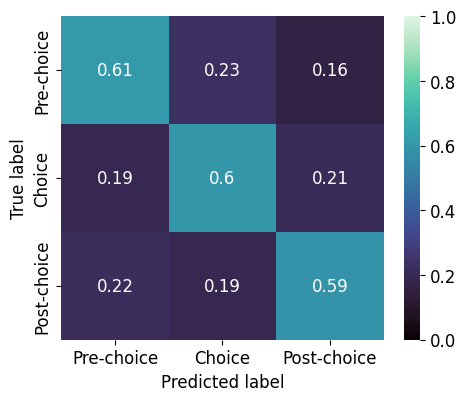

F1 results 0.5982339955849889


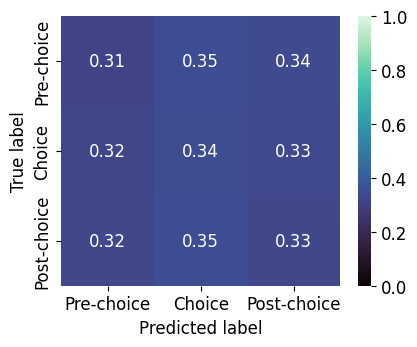

F1 shuffled results 0.32779249448123626


In [135]:
"""
PLOT RESULTS
"""

# -- Confusion Matrix
labels = np.array(mat[var])

# Results on original model
plt.rc('font', size=12) 
plt.figure(figsize=[5.2, 4.2])
hmap = sns.color_palette("mako", as_cmap=True)
data = decoding_result.loc[decoding_result['shuffle'] == 0]
sns.heatmap(data['confusion_matrix'].mean(), annot=True, 
    yticklabels=np.unique(labels.astype(int)), xticklabels=np.unique(labels.astype(int)), 
    cmap= hmap, vmin=0, vmax=1) 
# plt.xticks([.5, 1.5, 2.5], ['Pre-choice', 'Choice', 'Post-choice'])
# plt.yticks([.5, 1.5, 2.5], ['Pre-choice', 'Choice', 'Post-choice'])

plt.xticks([.5, 1.5, 2.5], ['Pre-choice', 'Choice', 'Post-choice'])
plt.yticks([.5, 1.5, 2.5], ['Pre-choice', 'Choice', 'Post-choice'])

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('full_cm.svg',dpi=500)
plt.show()
print('F1 results', data['f1'].mean())


# Results from shuffled model
plt.rc('font', size=12) 
plt.figure(figsize=[4.5, 3.5])
# data = decoding_result.loc[decoding_result['shuffle'] == 1]
data = decoding_result.loc[decoding_result['shuffle'] >0]
sns.heatmap(data['confusion_matrix'].mean(), annot=True, 
    yticklabels=np.unique(labels), xticklabels=np.unique(labels), 
    cmap= hmap, vmin=0, vmax=1)
plt.xticks([.5, 1.5, 2.5], ['Pre-choice', 'Choice', 'Post-choice'])
plt.yticks([.5, 1.5, 2.5], ['Pre-choice', 'Choice', 'Post-choice'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
print('F1 shuffled results',  data['f1'].mean())



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


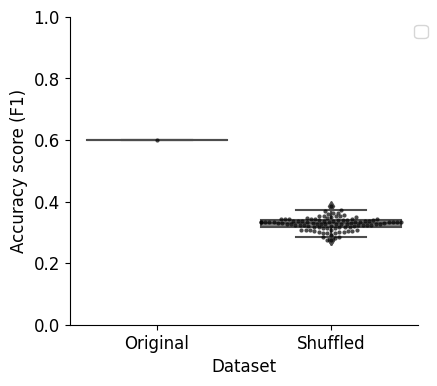

In [136]:
# -- F1 score per model, original and shuffled
data = decoding_result.copy()
data['f1'] = data['f1'].astype(float)

data.loc[data['shuffle'] >= 1, 'shuffle'] = 'Shuffled'
data.loc[data['shuffle'] == 0, 'shuffle'] = 'Original'
data = data.rename(columns={'shuffle': 'Dataset'})

plt.rc('font', size=12) 
plt.figure(figsize=[4.5, 4])
sns.boxplot(y='f1', x='Dataset', data=data, color='grey') 
sns.swarmplot(y='f1', x='Dataset', data=data, color='black', dodge=True, alpha=0.7, size=3)
plt.ylim([0,1])
plt.ylabel('Accuracy score (F1)')
plt.legend(bbox_to_anchor=(1.05, 1))
sns.despine(top=True, right=True)
#plt.savefig('violin.svg',dpi=500)

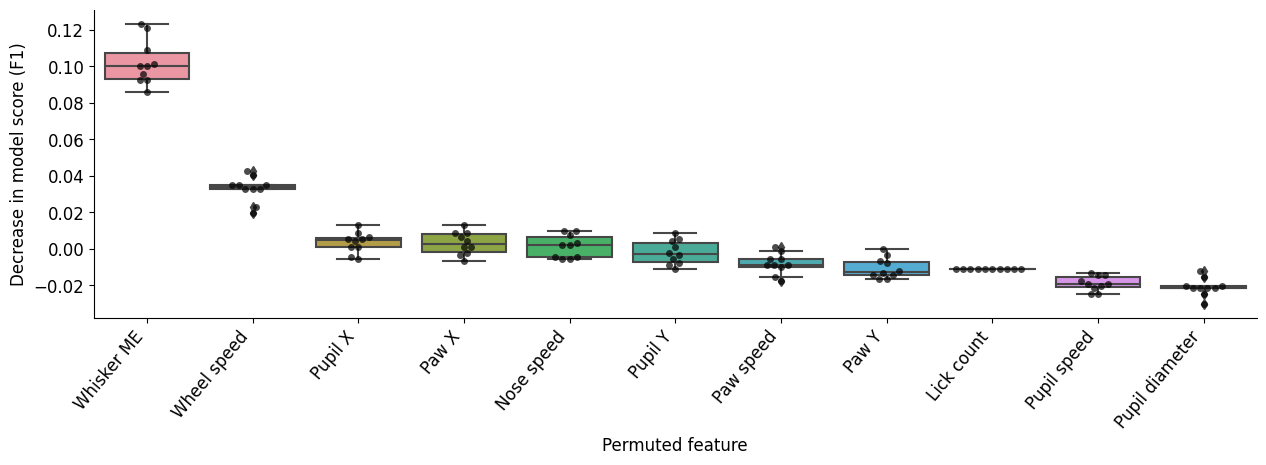

In [137]:
# -- Permutation tests for full model
f1_full_model = decoding_result.loc[decoding_result['shuffle']==0, 'f1'][0]
data = permutation_result.copy()
data['f1'] = data['f1'].astype(float)
data['f1'] = original_f1 - data['f1']
data = data.replace(var_names, ['Wheel speed', 'Pupil diameter',
    'Whisker ME', 'Nose speed', 'Paw speed', 
    'Paw X', 'Paw Y',
    'Pupil speed', 'Pupil X', 'Pupil Y', 'Lick count'])

plot_order = data.groupby('feature')['f1'].mean().sort_values(ascending=False).index.values
plt.figure(figsize=[15,4])
plt.rc('font', size=12) 
sns.boxplot(x='feature', y='f1', data=data, 
    order=plot_order, orient='v') 
sns.swarmplot(x='feature', y='f1', data=data, 
    order=plot_order, orient='v', color='black', alpha=0.7) 
plt.xlabel('Permuted feature')
plt.ylabel('Decrease in model score (F1)')
ha = 'right'
plt.xticks(rotation=50, ha=ha)
sns.despine(top=True, right=True)
plt.savefig('permutation_importances.svg',dpi=500)
